# Time Series Analysis and Forecasting

This is a series of notebooks to support lectures on _Time series analysis and forecast_.

![](https://user-images.githubusercontent.com/49638680/154160268-cf39a1ec-3557-4940-8853-d06fc7a79acf.png)

## Time series Forecast

In paticular, over this notebook we are going to use some Recurrent Neural Network architectures in order to implement a forecast of future values of an univariate time series, performing and discussing hyperparameters tuning.

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

As usual, we import data as a pandas dataframe, parsing time index in the correct way.

In [2]:
df = pd.read_csv('datasets/alcohol_sales.csv', 
                 index_col='Date', 
                 parse_dates=True)

df.index.freq = 'MS'

In [3]:
df.shape

(336, 1)

### Data analysis

Just as an exercise let's analyse our series to get a clearer understaing of it.

##### Plot the series

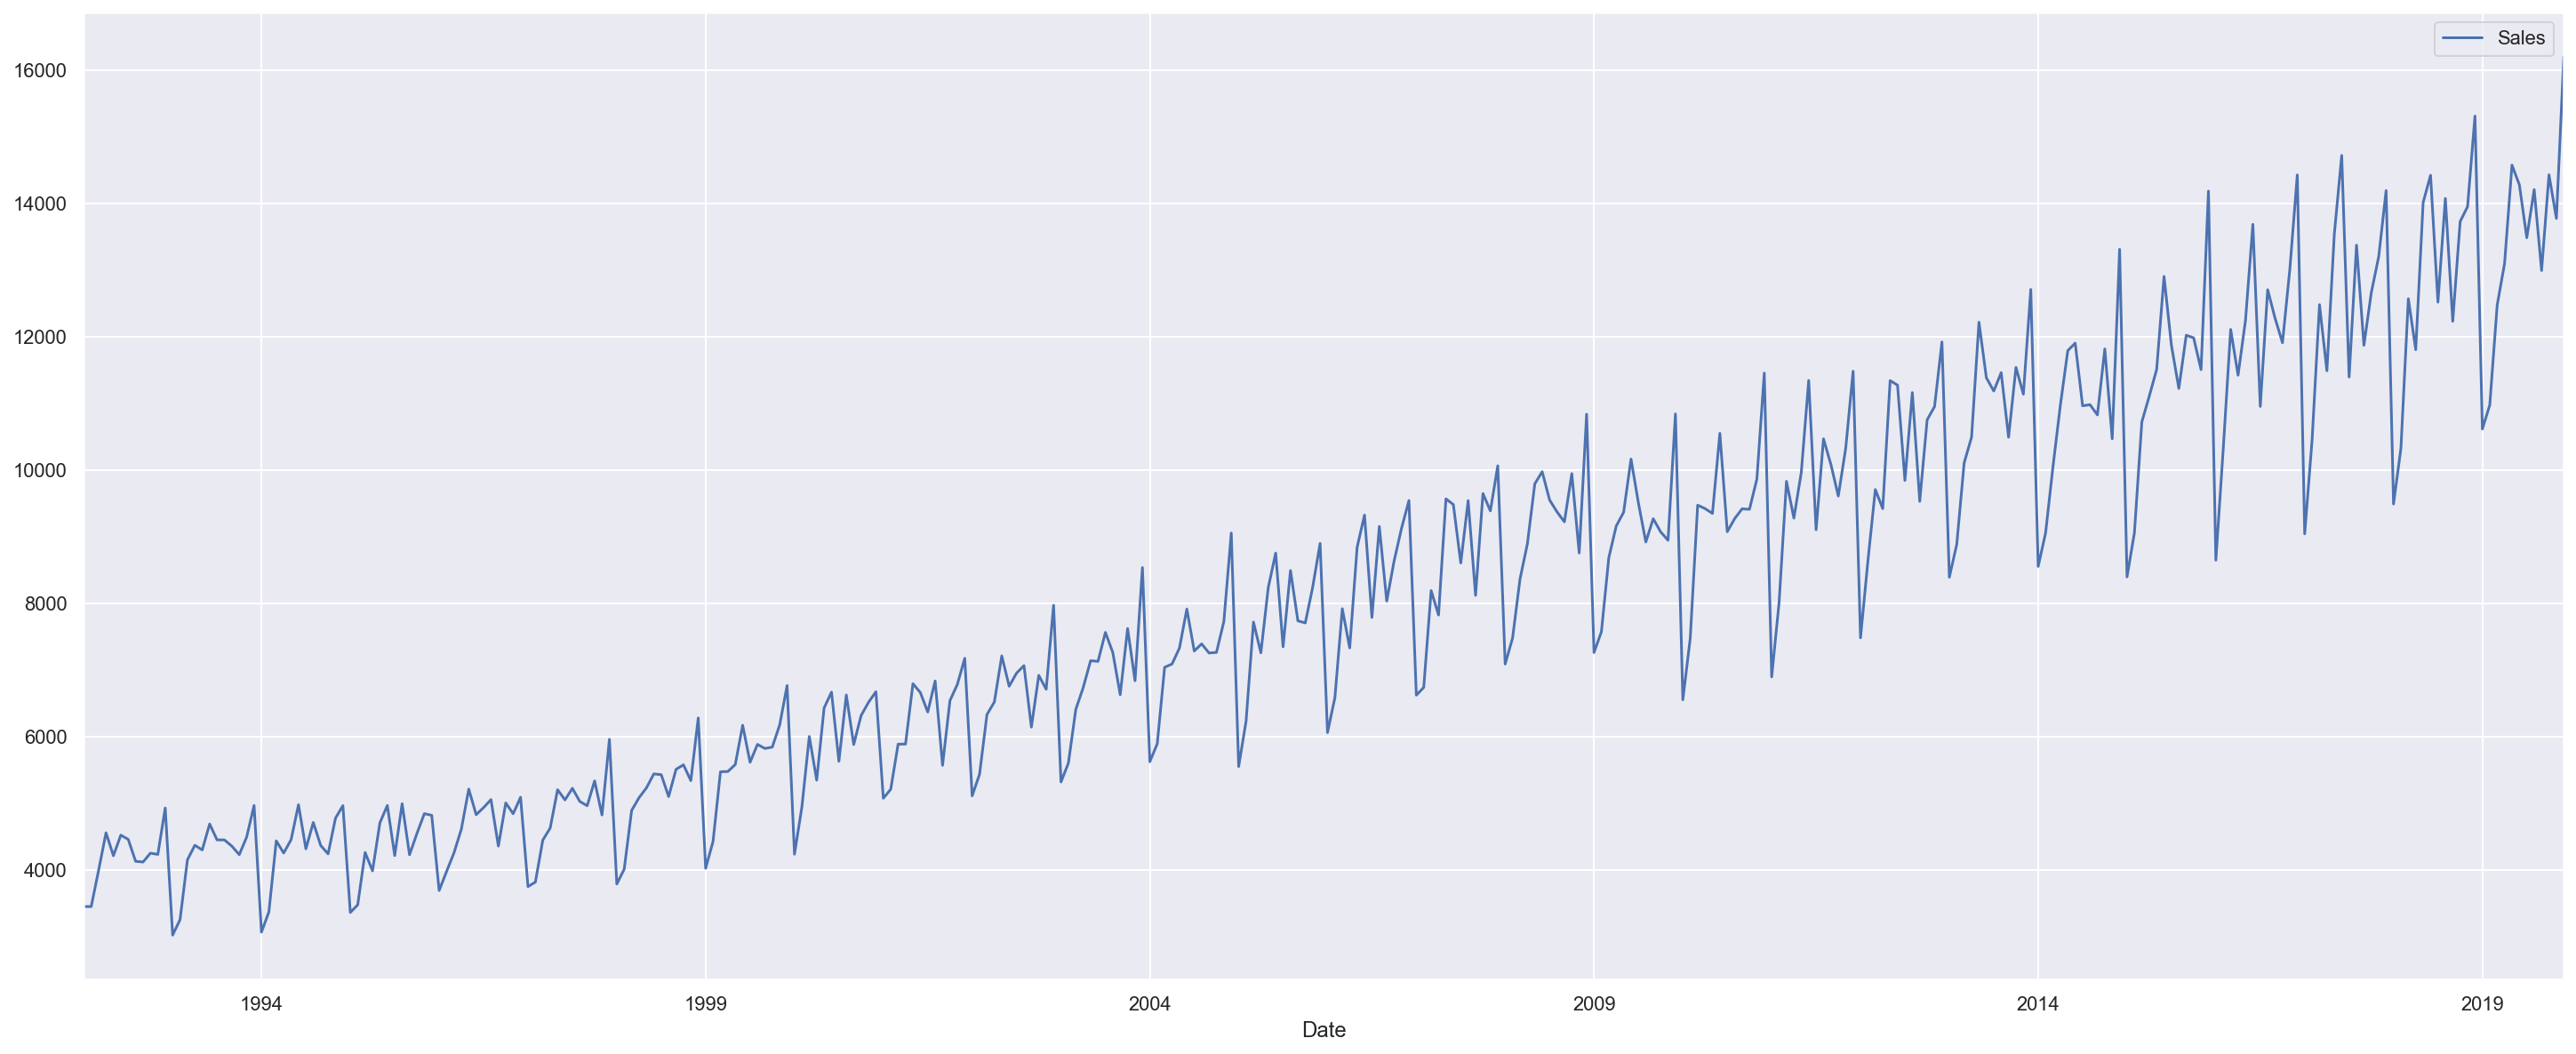

In [10]:
df.plot();

##### Get rid of Trend

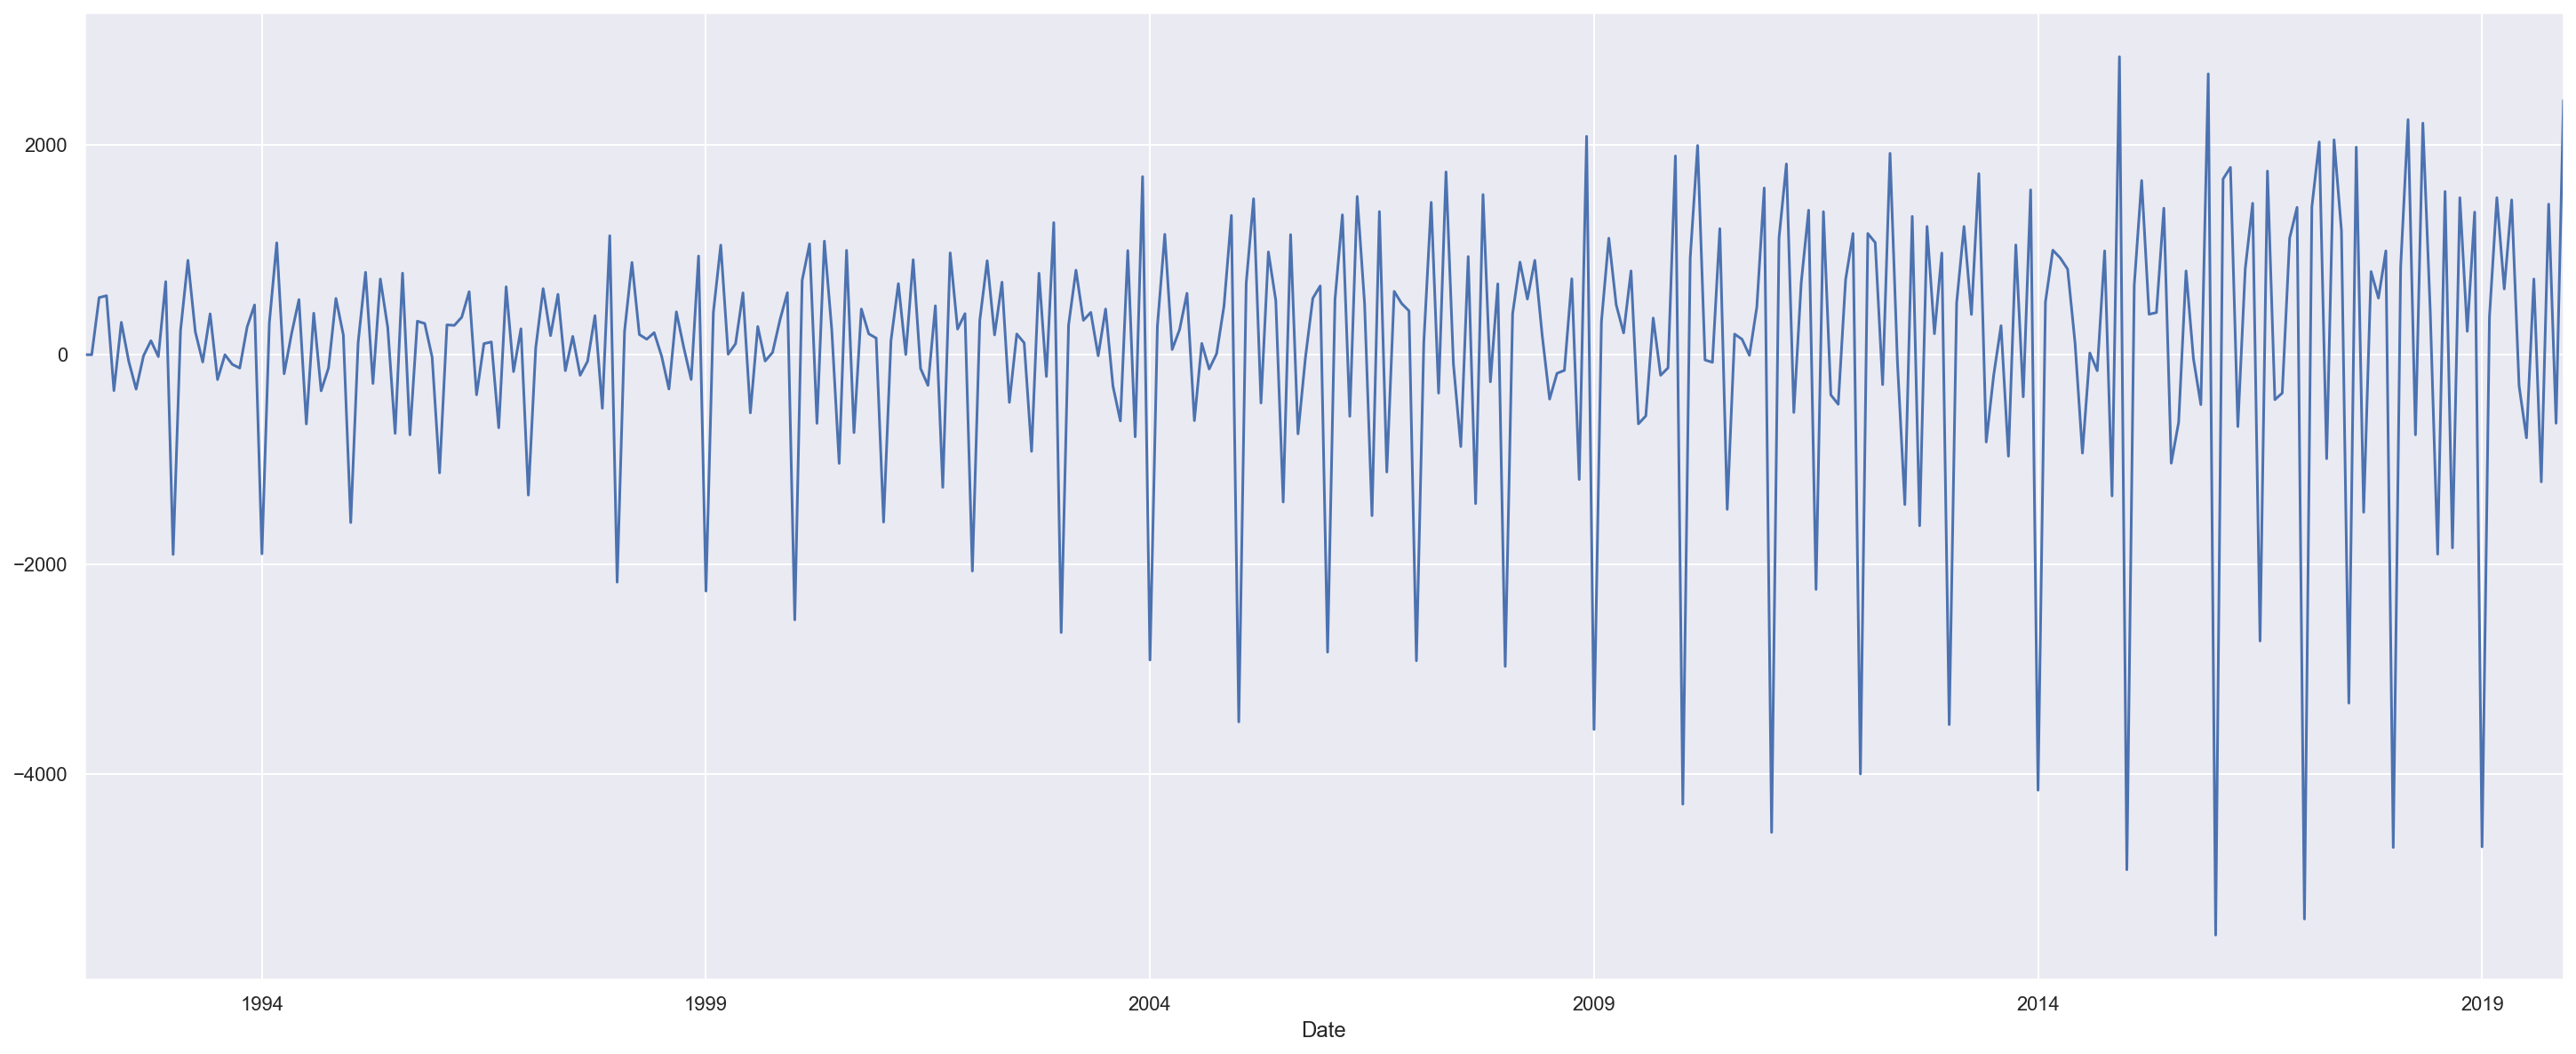

In [5]:
df_copy = df.copy() # to not spoil actual data

df_copy["SalesDiff"] = df["Sales"].diff().fillna(value=0)
df_copy["SalesDiff"].plot();

Let's analyse weekends behaviour.

In [6]:
df_copy["Year"] = df.index.year
df_copy["Month"] = df.index.month
df_copy["Day"] = df.index.day
df_copy["Weekday"] = df.index.day_name()
df_copy["IsWeekend"] = np.where(df_copy["Weekday"].isin(["Friday", "Saturday", "Sunday"]), 1, 0)
df_copy

,Sales,SalesDiff,Year,Month,Day,Weekday,IsWeekend
Date,,,,,,,
1992-01-01,3459,0.0,1992,1,1,Wednesday,0
1992-02-01,3458,-1.0,1992,2,1,Saturday,1
1992-03-01,4002,544.0,1992,3,1,Sunday,1
1992-04-01,4564,562.0,1992,4,1,Wednesday,0
1992-05-01,4221,-343.0,1992,5,1,Friday,1
...,...,...,...,...,...,...,...
2019-08-01,14205,721.0,2019,8,1,Thursday,0
2019-09-01,12992,-1213.0,2019,9,1,Sunday,1
2019-10-01,14427,1435.0,2019,10,1,Tuesday,0


In [7]:
df_copy[df_copy["Sales"] >= df_copy["Sales"].quantile(q=0.99)]

,Sales,SalesDiff,Year,Month,Day,Weekday,IsWeekend
Date,,,,,,,
2017-06-01,14717,1180.0,2017,6,1,Thursday,0
2018-12-01,15308,1359.0,2018,12,1,Saturday,1
2019-05-01,14573,1475.0,2019,5,1,Wednesday,0
2019-12-01,16197,2424.0,2019,12,1,Sunday,1


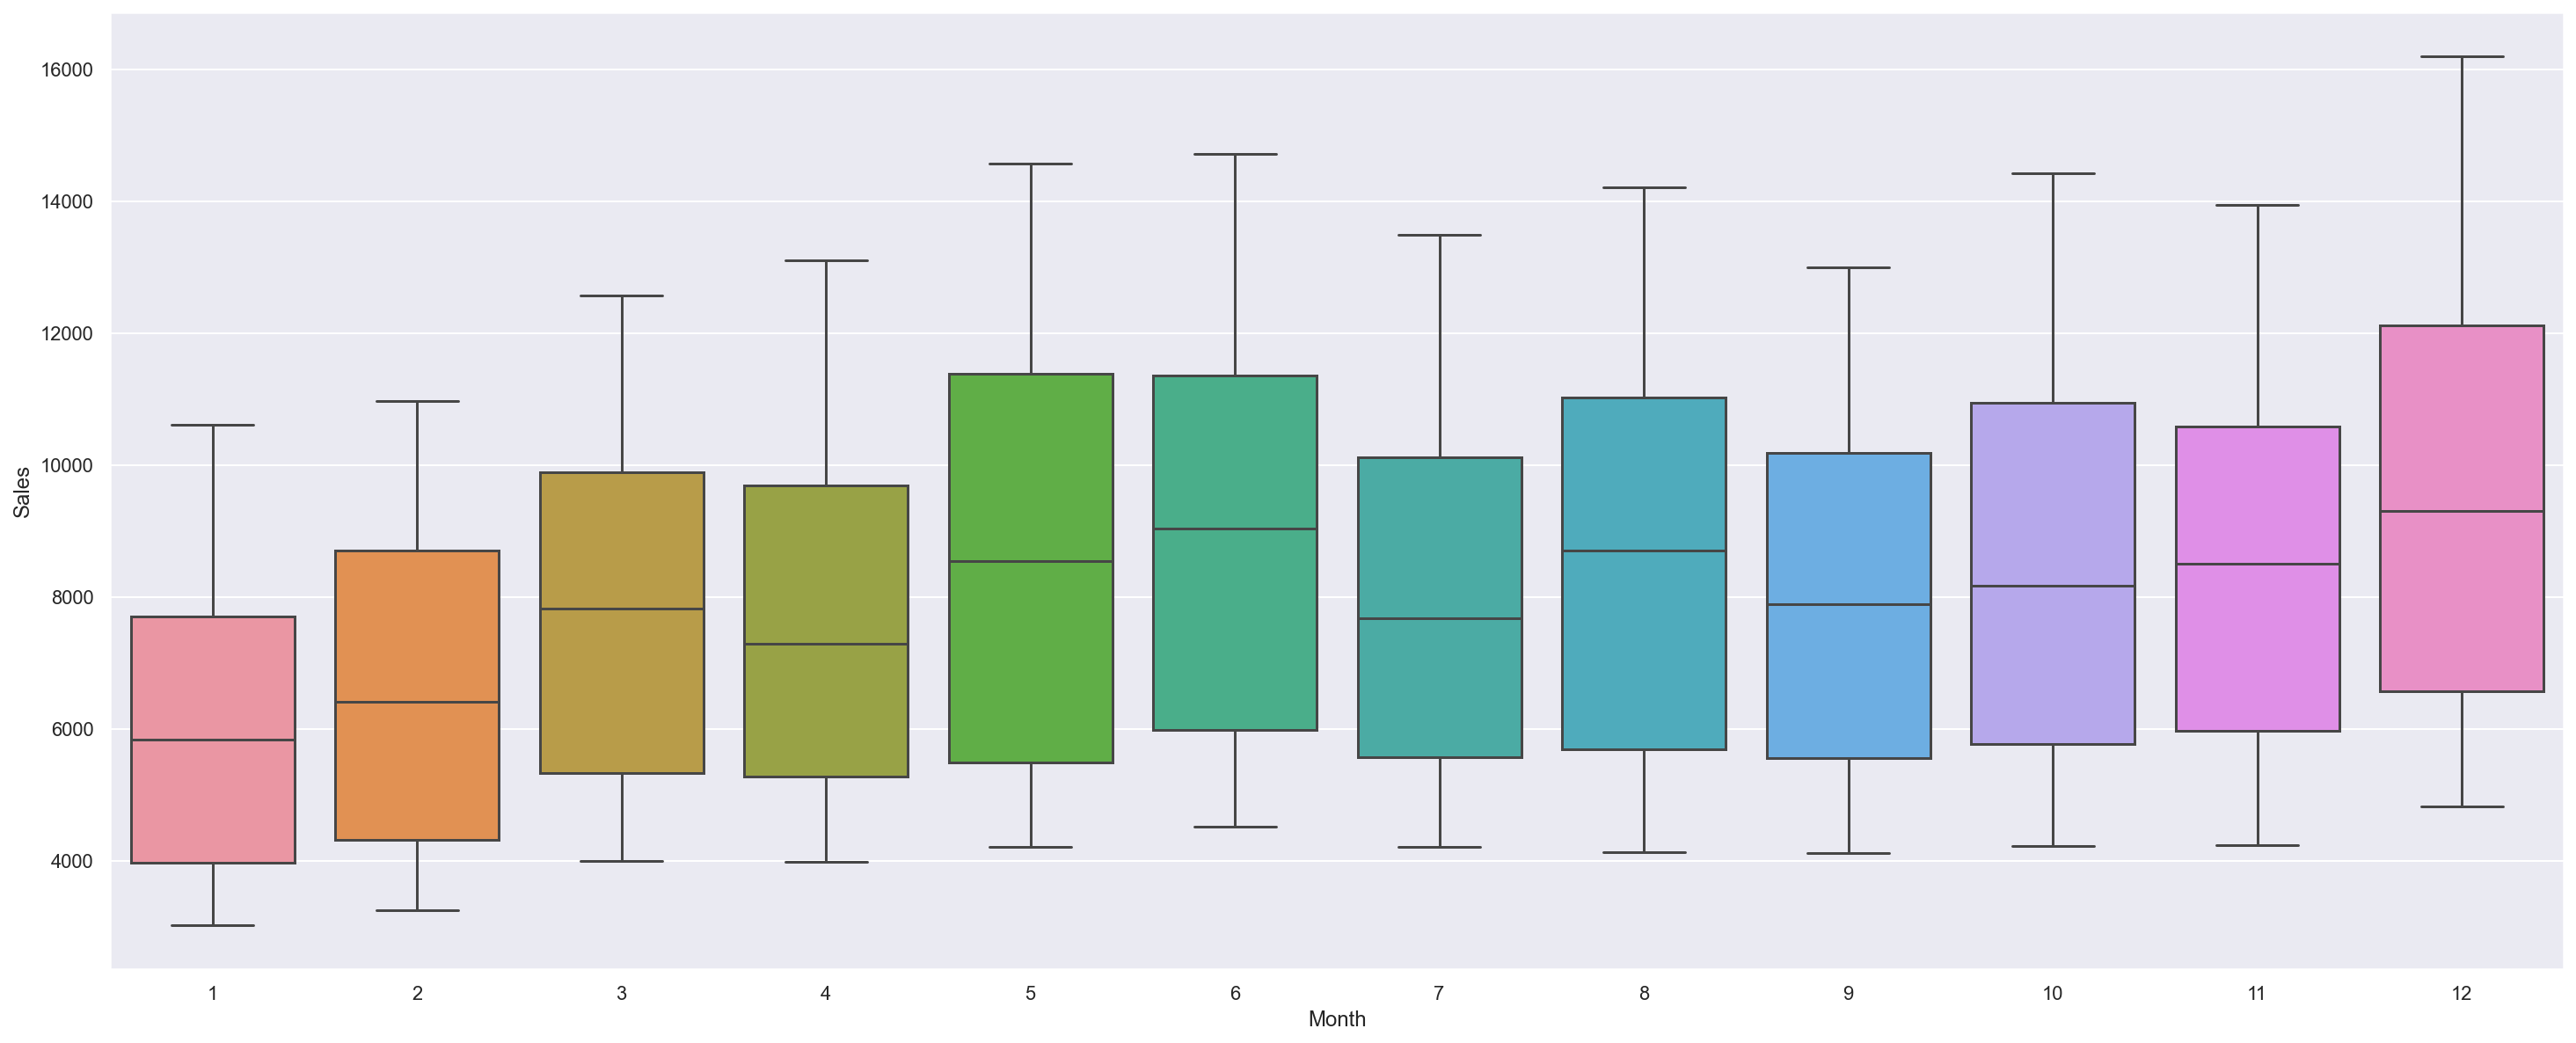

In [8]:
sns.boxplot(x="Month", y="Sales", data=df_copy);

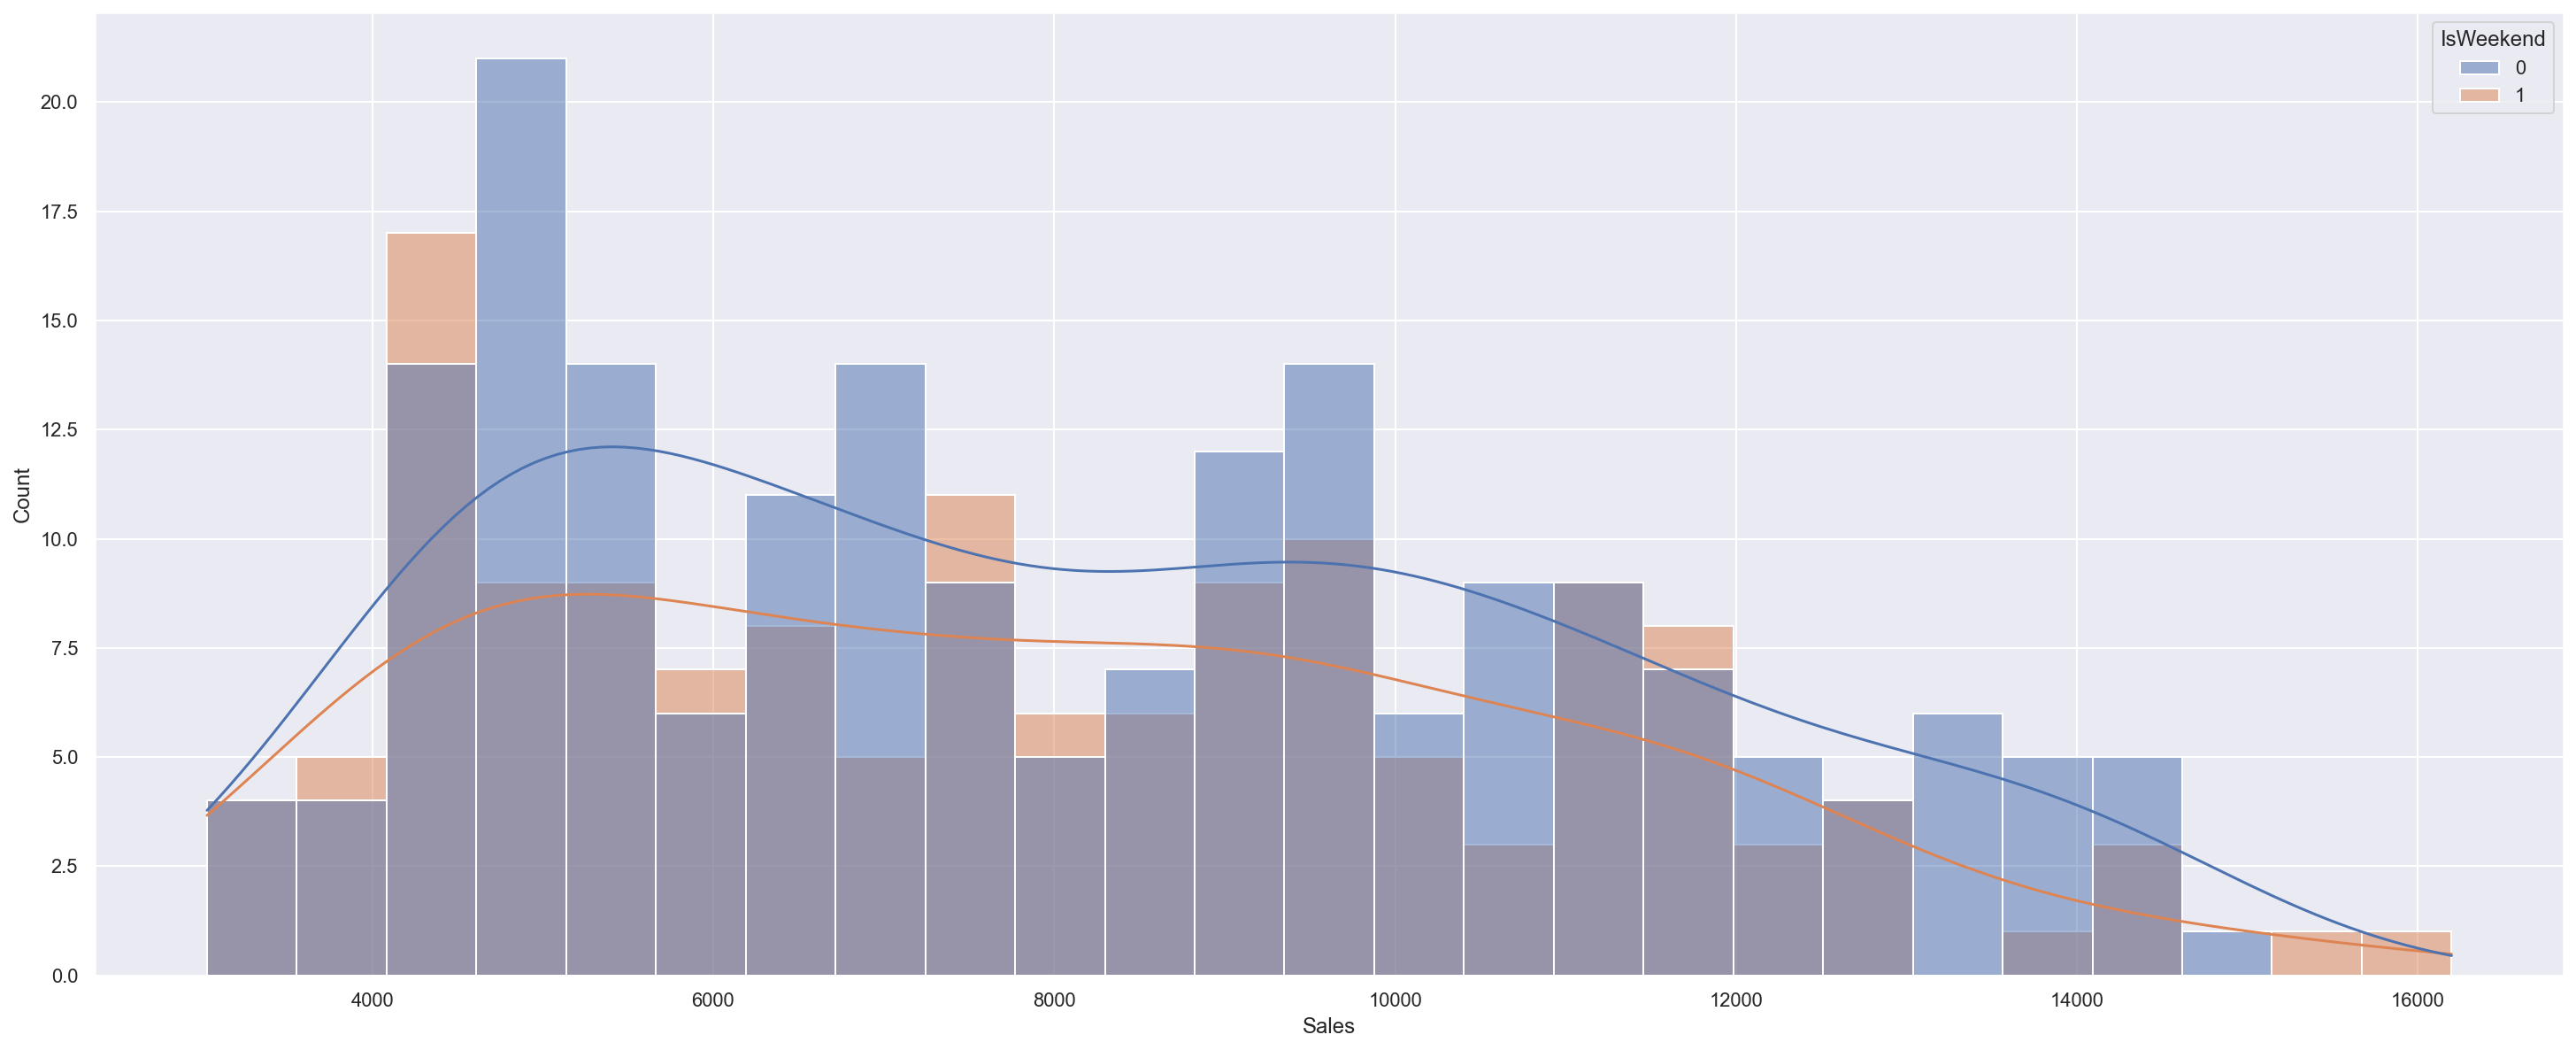

In [9]:
sns.histplot(x="Sales", hue="IsWeekend", bins=25, kde=True, data=df_copy);

### Autocorrelation

In [11]:
df[["Sales"]]

,Sales
Date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2019-08-01,14205
2019-09-01,12992
2019-10-01,14427


Let's apply a shift.

In [12]:
df["Sales"].shift(50)

Date
1992-01-01        NaN
1992-02-01        NaN
1992-03-01        NaN
1992-04-01        NaN
1992-05-01        NaN
               ...   
2019-08-01    12904.0
2019-09-01    11869.0
2019-10-01    11224.0
2019-11-01    12022.0
2019-12-01    11983.0
Freq: MS, Name: Sales, Length: 336, dtype: float64

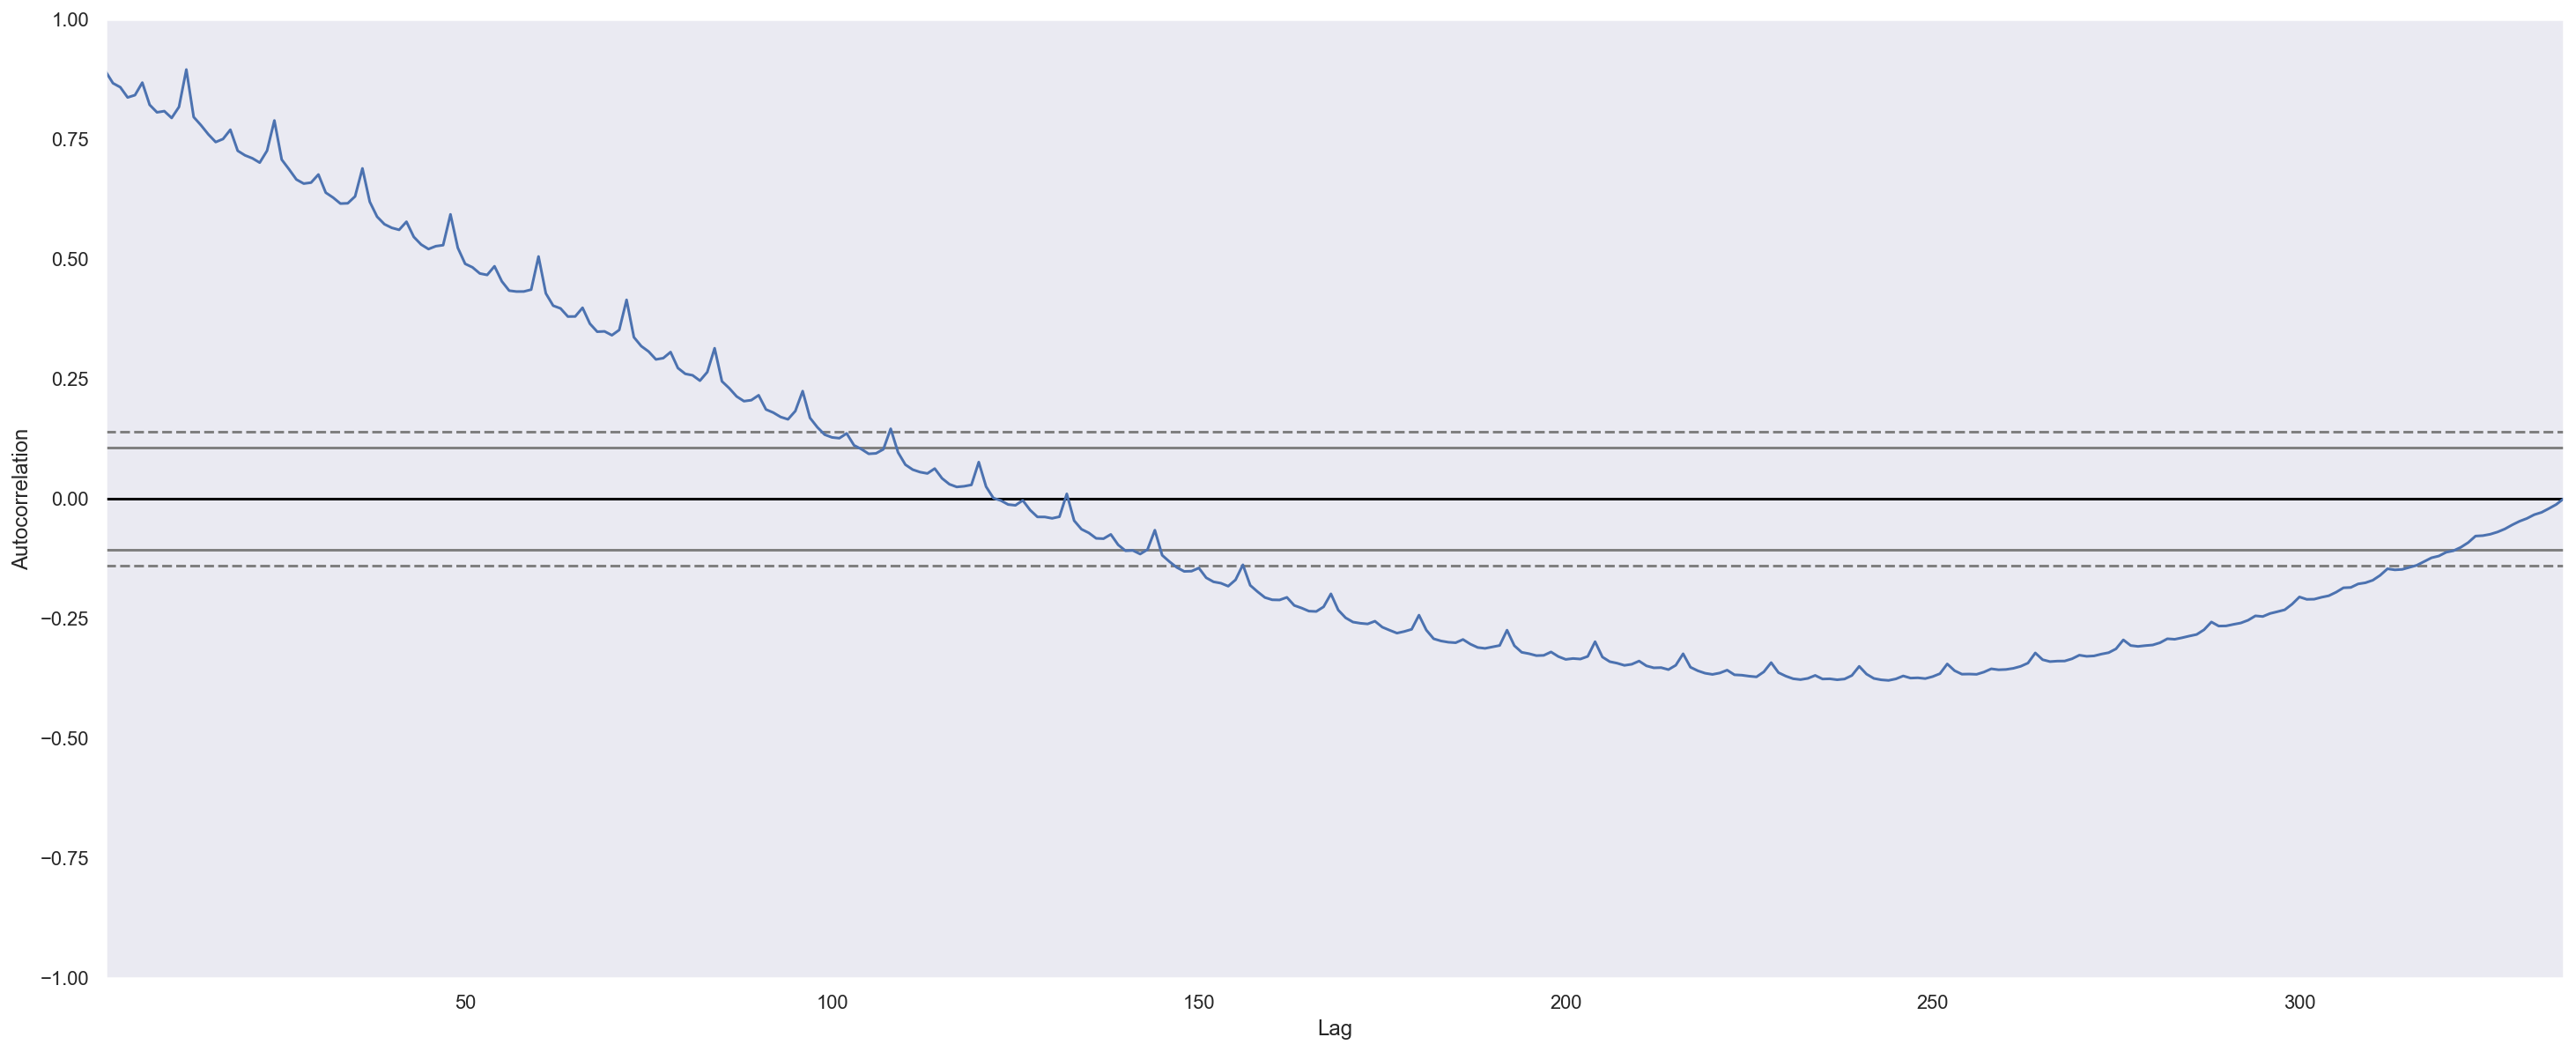

In [15]:
pd.plotting.autocorrelation_plot(df["Sales"]);

#### Lag Plot

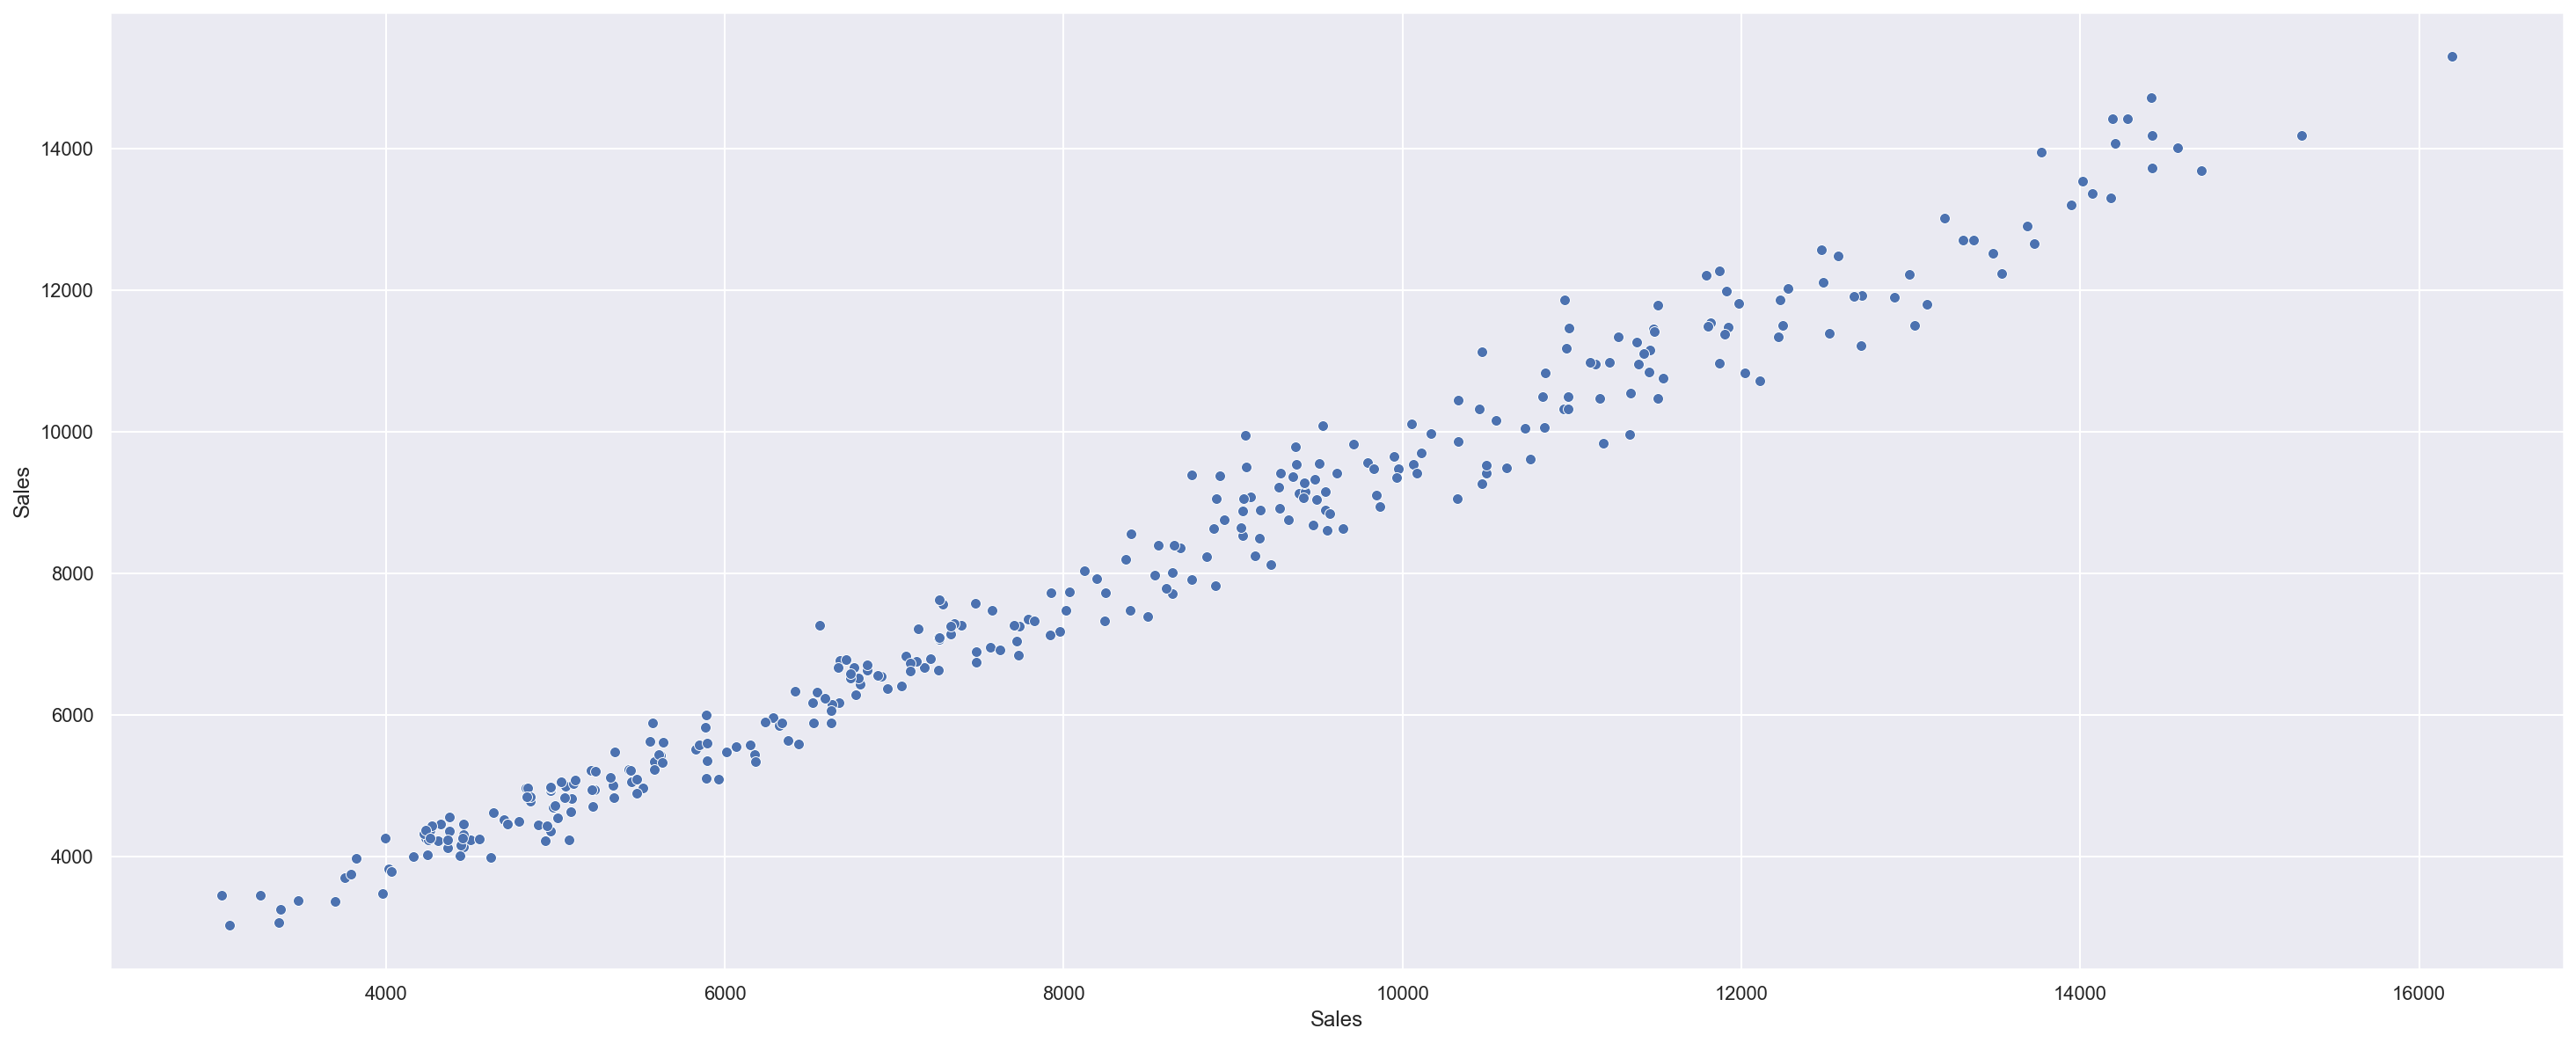

In [18]:
sns.scatterplot(x = df["Sales"], y = df["Sales"].shift(12));

Let's explore further this clear autocorrelation, by printing the correlation coefficients.

In [19]:
np.corrcoef(df["Sales"], df["Sales"].shift(12).fillna(0))

array([[1.        , 0.96613039],
       [0.96613039, 1.        ]])

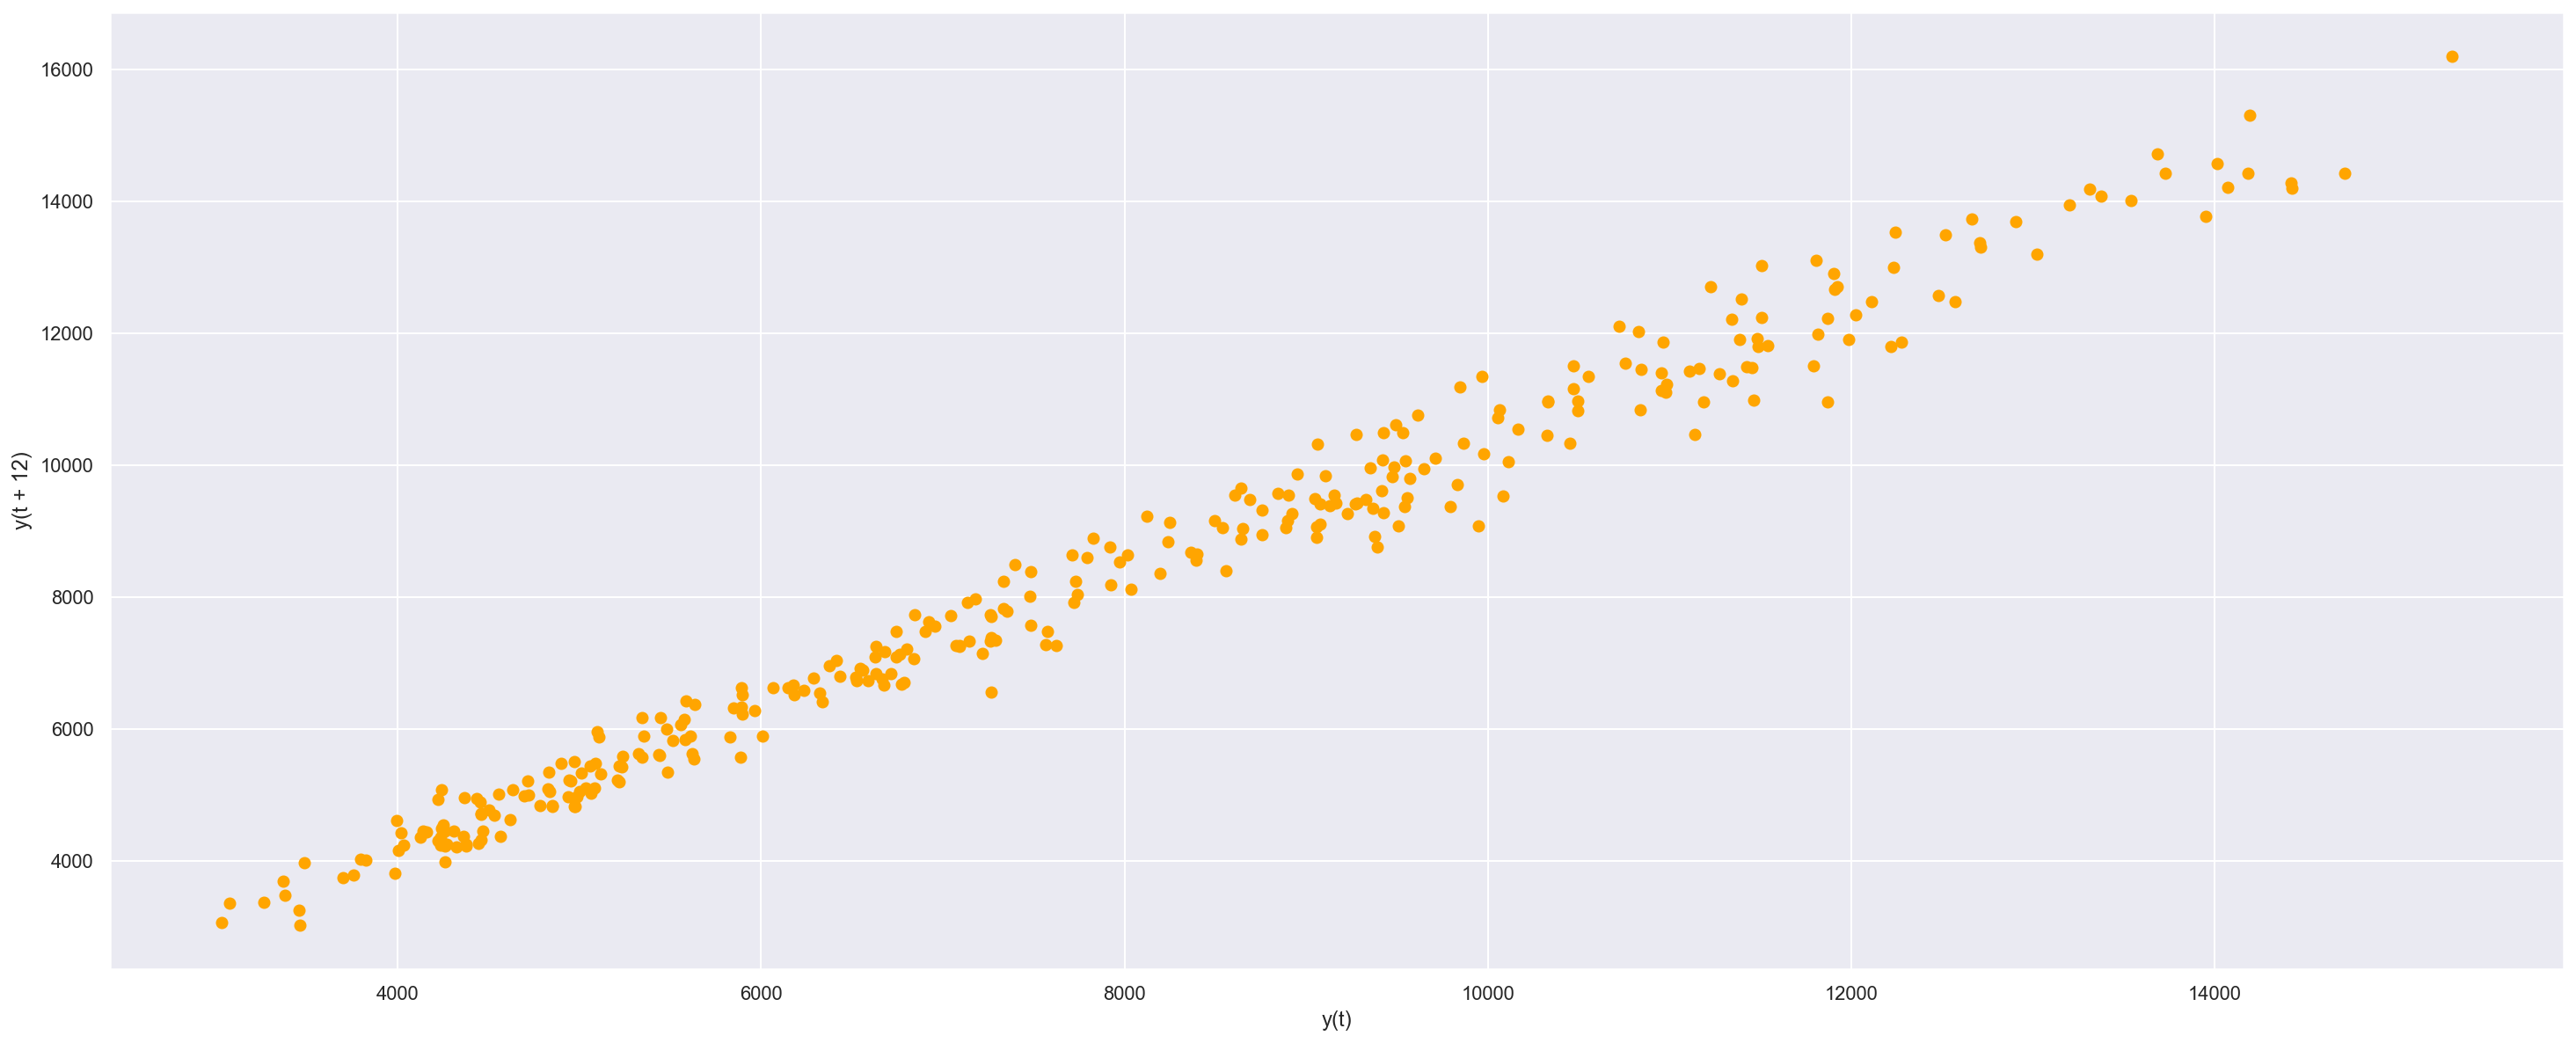

In [22]:
pd.plotting.lag_plot(df["Sales"], lag=12, c='orange');

### Further analysis: Series decomposition

We can apply what we have seen in previous lectures with time series decomposition

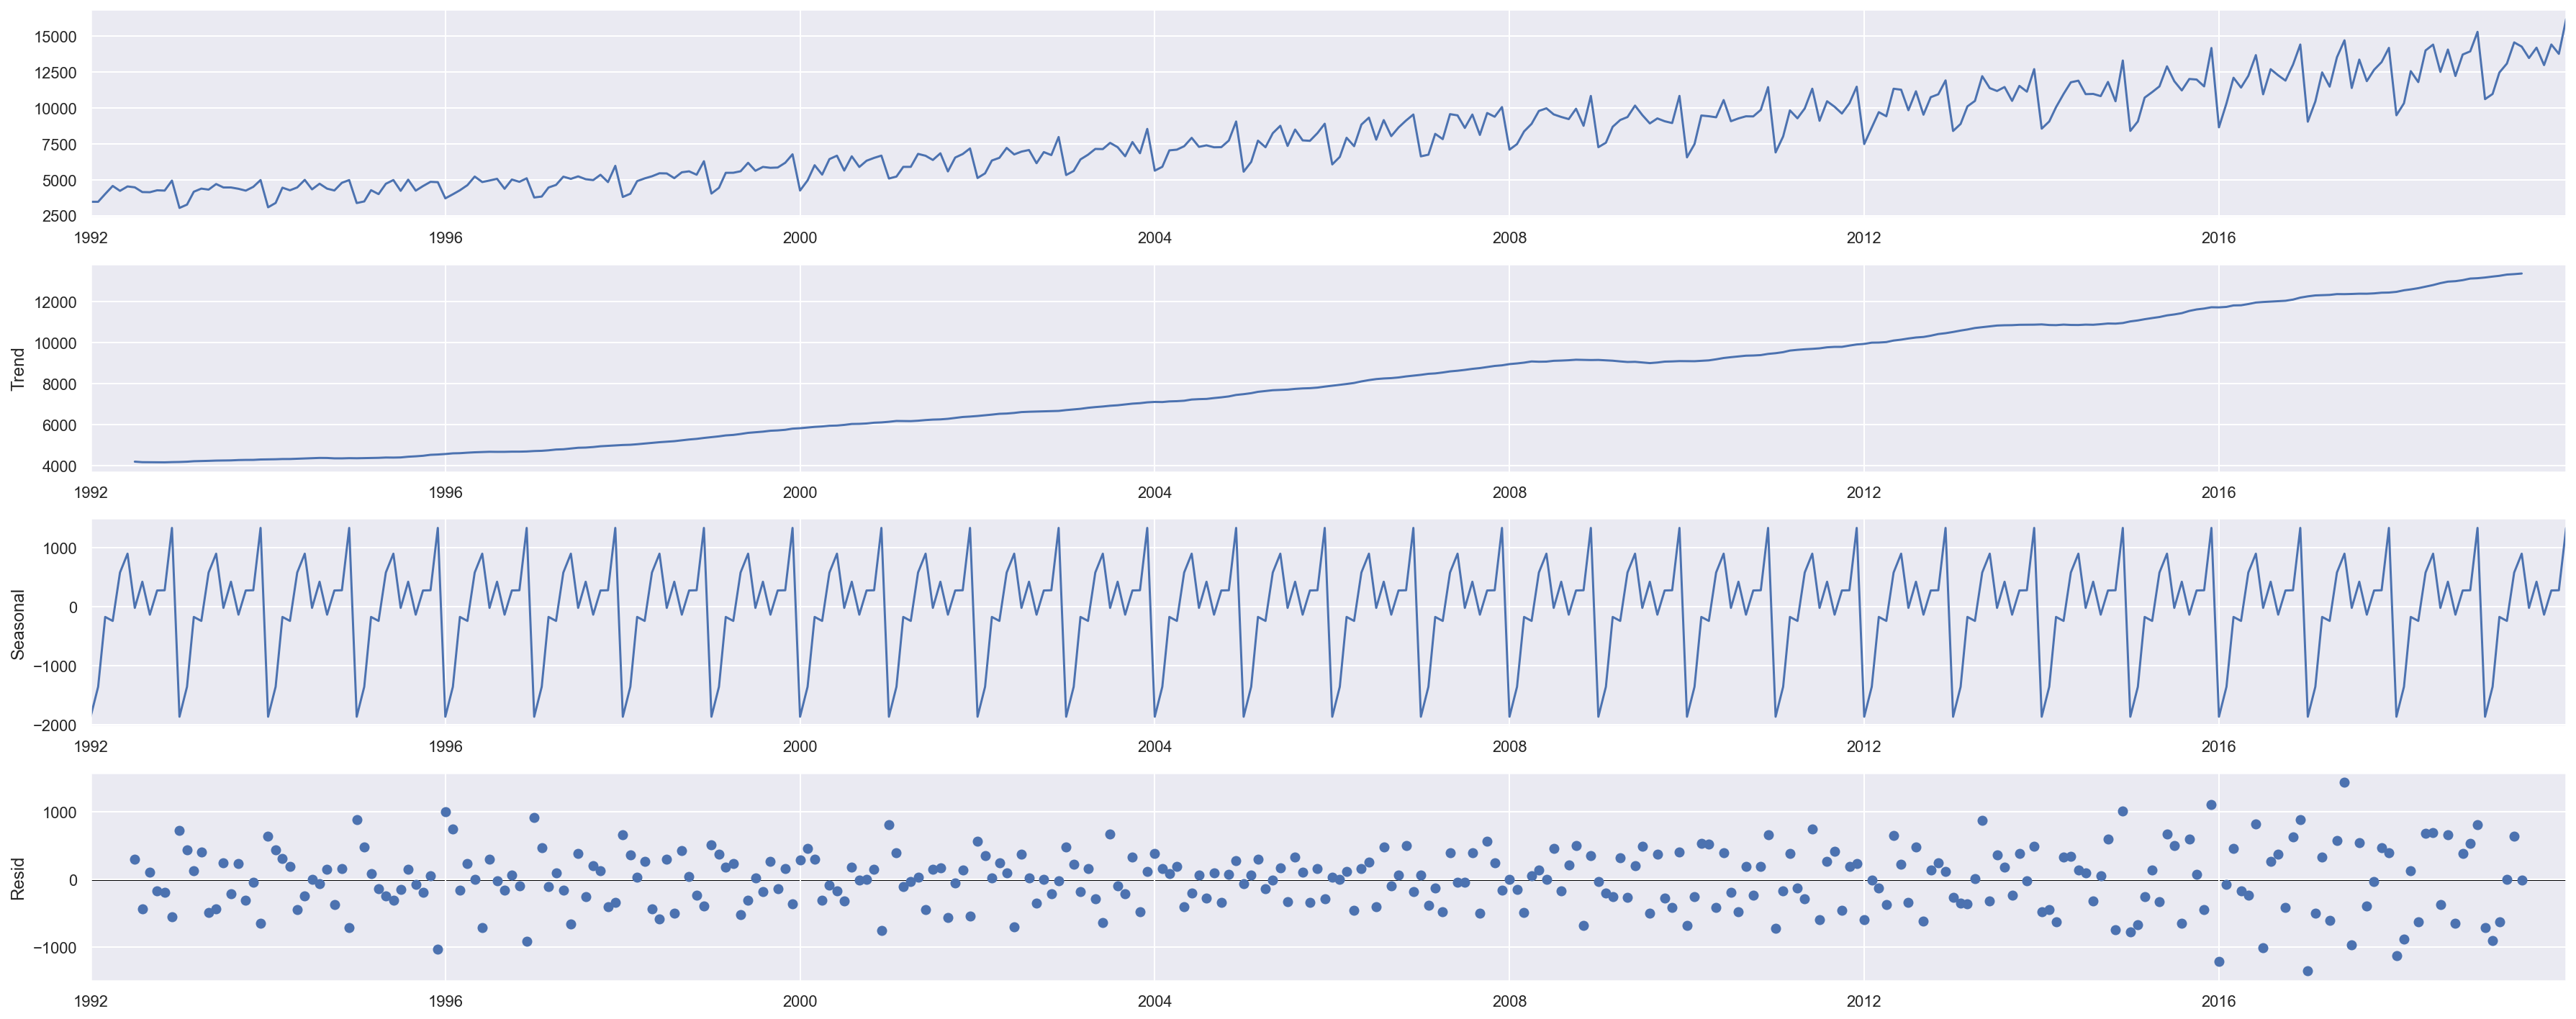

In [23]:
decomposition = seasonal_decompose(df)
decomposition.plot();

And print out the details

In [26]:
print(f"number of observations: {decomposition.nobs},",
      "\n",
      f"\n Original series: {decomposition.observed},",
      "\n",
      f"\n Trend series: {decomposition.trend},",
      "\n",
      f"\n Seasonality: {decomposition.seasonal},",
      "\n",
      f"\n Residualss: {decomposition.resid}")

number of observations: (336,), 
 
 Original series: Date
1992-01-01     3459.0
1992-02-01     3458.0
1992-03-01     4002.0
1992-04-01     4564.0
1992-05-01     4221.0
               ...   
2019-08-01    14205.0
2019-09-01    12992.0
2019-10-01    14427.0
2019-11-01    13773.0
2019-12-01    16197.0
Freq: MS, Length: 336, dtype: float64, 
 
 Trend series: Date
1992-01-01   NaN
1992-02-01   NaN
1992-03-01   NaN
1992-04-01   NaN
1992-05-01   NaN
              ..
2019-08-01   NaN
2019-09-01   NaN
2019-10-01   NaN
2019-11-01   NaN
2019-12-01   NaN
Freq: MS, Name: trend, Length: 336, dtype: float64, 
 
 Seasonality: Date
1992-01-01   -1863.603781
1992-02-01   -1356.353781
1992-03-01    -173.313657
1992-04-01    -240.538966
1992-05-01     579.169367
                 ...     
2019-08-01     422.914738
2019-09-01    -134.572917
2019-10-01     275.186343
2019-11-01     278.522762
2019-12-01    1334.578318
Freq: MS, Name: seasonal, Length: 336, dtype: float64, 
 
 Residualss: Date
1992-01-01   Na

---
### Ready to forecast: train, test

We are now ready to prepare our time series to feed the model. We want to split the series in train and test data.

It is quite simple: we want to use $2019$ data as a test, the previous ones as training set.

In [27]:
train = df.loc[:"2018"]
test = df.loc["2019"]

We scale data between $0$ and $1$.

In [28]:
mms = MinMaxScaler()
mms.fit(train);

In [29]:
scaled_train = mms.transform(train)
scaled_test = mms.transform(test)

#### TimeSeriesGenerator
At this point, we need to find a way to process data in a _rolling window_, that is, given $n$ months batch, we want the model to predict the future one. In order to do so, we can take advantage of one of the great tools tensorflow has built-in: [**TimeSeriesGenerator**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator). This method takes training data as input, splits them into features and target. Recall that our goal is to be able to predict one month in future having $12$ months in the past:

In order to do so one has to instanciate a `TimeSeriesGenerator` object with the following parameters:
* `data` = scaled training data
* `targets` = scaled training data
* `length` = $12$
* `batch_size` = $1$

For further details on TimeSeriesGenerator method one can read:

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator
* tutorial: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [30]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=12, batch_size=1)

Let's visualise the first generated series.

In [32]:
X, y = generator[0]
print("X: ", X.flatten())
print("y: ", y)

X:  [0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
y:  [[0.]]


As any other good generator, this is supposed to be used in an iterative process.

In [33]:
data = []
for i, j in generator:
    data.append({"features": i.flatten(), "target": j[0][0]})
    
df_generator = pd.DataFrame(data)

In [34]:
df_generator

,features,target
0,"[0.0348619369552822, 0.03478048383155494, 0.07...",0.000000
1,"[0.03478048383155494, 0.07909098313920335, 0.1...",0.018734
2,"[0.07909098313920335, 0.1248676386739431, 0.09...",0.091961
3,"[0.1248676386739431, 0.09692921723548095, 0.12...",0.109636
4,"[0.09692921723548095, 0.12201677934348779, 0.1...",0.103934
...,...,...
307,"[0.8423882055876841, 0.7200456137492872, 0.784...",0.899405
308,"[0.7200456137492872, 0.7845564877413047, 0.828...",0.749369
309,"[0.7845564877413047, 0.8284597214303169, 0.909...",0.871223
310,"[0.8284597214303169, 0.9090168607966114, 0.526...",0.889305


---
## The kraken: model training

Finally, we are ready to train our model on data.

We can define different models in order to compare their performances and choose the best one.

We are going to build the following models architectures:

* SimpleRNN
* LSTM
* 2-layers LSTM
* GRU

In [37]:
def rnn_model(activation):
    model = Sequential()
    model.add(SimpleRNN(units=120, activation=activation, input_shape=(12, 1)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

def lstm_model():
    model = Sequential([
        LSTM(units=120, activation="relu", input_shape=(12, 1)), 
        Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse")
    return model

def deep_lstm_model():
    i = Input(shape=(12, 1))
    x = LSTM(units=90, activation="relu", return_sequences=True)(i)
    x = LSTM(units=30, activation="relu")(x)
    x = Dense(1)(x)
    model = Model(i, x)
    model.compile(optimizer="rmsprop", loss="mse")
    return model

def gru_model():
    model = Sequential()
    model.add(GRU(units=120, activation="relu", input_shape=(12, 1)))
    model.add(Dense(1))
    model.compile(optimizer="rmsprop", loss="mse")
    return model

### RNN tanh

Let's define a Vanilla RNN with tanh activation function.

In [38]:
rnn_tanh = rnn_model(activation="tanh")
rnn_tanh.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 120)               14640     
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


### RNN relu

Let's define a Vanilla RNN with rectified linear unit activation function.

In [39]:
rnn_relu = rnn_model(activation="relu")
rnn_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 120)               14640     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


### LSTM

Let's define an LSTM network with just one layer.

In [40]:
lstm = lstm_model()
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dense_3 (Dense)             (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


### LSTM multilayer

And analogously a multilayer LSTM.

In [41]:
lstm_deep = deep_lstm_model()
lstm_deep.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 90)            33120     
                                                                 
 lstm_2 (LSTM)               (None, 30)                14520     
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 47,671
Trainable params: 47,671
Non-trainable params: 0
_________________________________________________________________


### GRU
Finally a Gated Recurrent Unit

In [42]:
gru = gru_model()
gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 120)               44280     
                                                                 
 dense_5 (Dense)             (None, 1)                 121       
                                                                 
Total params: 44,401
Trainable params: 44,401
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping
During model training, we can choose to monitor some quantity in order to check over the model performances and eventually stop the training to avoid overfit. To this aim one can use the `EarlyStopping` method:

Let's instanciate an earlystopping callback with the follwoing parameters
* `monitor = "loss"`
* `min_delta = 1e-5`
* `patience = 5`
* `mode = "min"`

Meaning we are monitoring the model training loss, and if in five epochs it does not decrease by at least $1 \times 10^{-5}$, we stop the training.

Fur further details:
* docs: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
* tutorial: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [43]:
early_stopping = EarlyStopping(monitor="loss",  min_delta=1e-5, patience=5, mode="min")

#### Models fit

##### RNN tanh

In [45]:
rnn_tanh.fit(generator, epochs=50, callbacks=[early_stopping]);

Epoch 1/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 2/50
312/312 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 3/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 4/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0042
Epoch 5/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 6/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 7/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 8/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0044
Epoch 9/50
312/312 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 10/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0035
Epoch 11/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 13/50
312/312 [====

##### RNN relu

In [46]:
rnn_relu.fit(generator, epochs=50, callbacks=[early_stopping]);

Epoch 1/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 2/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 3/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0078
Epoch 4/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0045
Epoch 5/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 6/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 7/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 8/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 9/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 10/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 11/50
312/312 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 13/50
312/312 [====

##### LSTM

In [47]:
lstm.fit(generator, epochs=50, callbacks=[early_stopping]);

Epoch 1/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0161
Epoch 2/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0102
Epoch 3/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0091
Epoch 4/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 5/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0066
Epoch 6/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 7/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 8/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 9/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 10/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 11/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 12/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 13/50
312/312 [====

##### LSTM multilayer

In [48]:
lstm_deep.fit(generator, epochs=50, callbacks=[early_stopping]);

Epoch 1/50
312/312 [==============================] - 3s 5ms/step - loss: 0.0170
Epoch 2/50
312/312 [==============================] - 1s 5ms/step - loss: 0.0101
Epoch 3/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0098
Epoch 4/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0081
Epoch 5/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0079
Epoch 6/50
312/312 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 7/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0056
Epoch 8/50
312/312 [==============================] - 1s 5ms/step - loss: 0.0048
Epoch 9/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0038
Epoch 10/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0033
Epoch 11/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0031
Epoch 12/50
312/312 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 13/50
312/312 [====

##### GRU model

In [50]:
gru.fit(generator, epochs=50, callbacks=[early_stopping]);

Epoch 1/50
312/312 [==============================] - 2s 3ms/step - loss: 0.0214
Epoch 2/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0104
Epoch 3/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0100
Epoch 4/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0087
Epoch 5/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0090
Epoch 6/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0083
Epoch 7/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 8/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 9/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 10/50
312/312 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 11/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 12/50
312/312 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 13/50
312/312 [====

### Plot Learning curves for each model

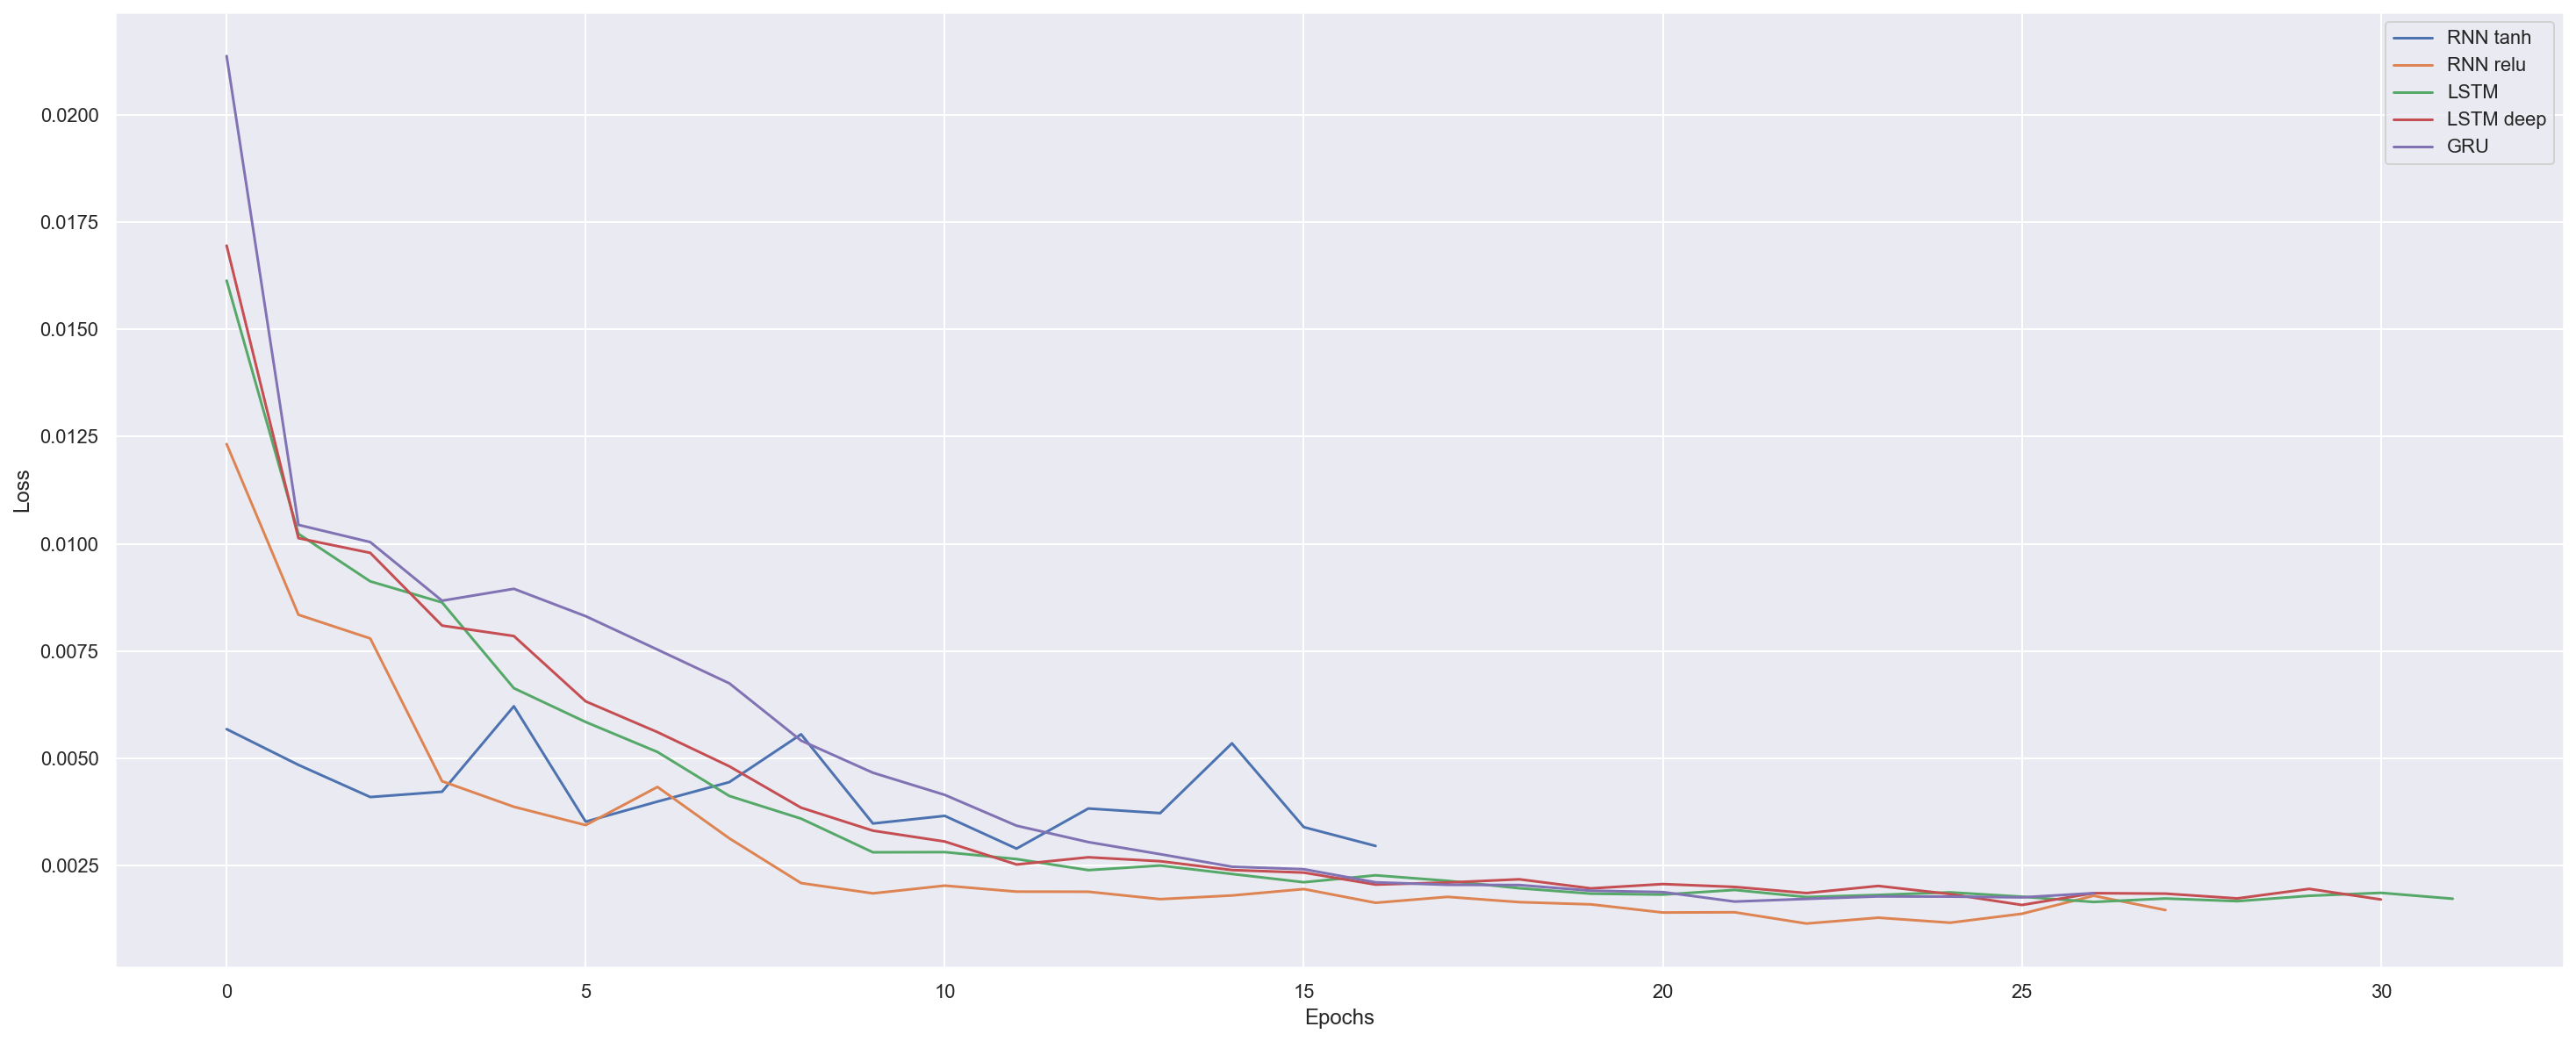

In [54]:
fig = plt.figure(figsize=(25, 10))
ax = fig.subplots()
pd.DataFrame(rnn_tanh.history.history).plot(ax=ax)
pd.DataFrame(rnn_relu.history.history).plot(ax=ax)
pd.DataFrame(lstm.history.history).plot(ax=ax)
pd.DataFrame(lstm_deep.history.history).plot(ax=ax)
pd.DataFrame(gru.history.history).plot(ax=ax)
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.legend(["RNN tanh","RNN relu", "LSTM", "LSTM deep", "GRU"]);

### Inference over the test set

We are now ready to use our trained models and predict the behaviour of the time series.
Recall that we applied some preprocessing to data (scaling, etc.), hence we need to invert such transformations in order to 
Let's define a function to take care of the different steps.

In [55]:
def get_model_predictions(train, test, model):
    """
    Create prediction for RNN model fitted with generator
    
    Parameters
    ----------
    train : np.array
        training scaled data
    test : np.array | pd.DataFrame
        test data
    model : keras.model
        keras RNN model
    
    Returns
    -------
    list
        model predictions
    """
    y_hat = []
    batch = train[-12:].reshape((1, 12, 1))
    for i in range(len(test)):
        # calculate predictions 1 month forward 
        # [0] to get the actual value, model.predict returns an array.
        new_pred = model.predict(batch)[0]
        # save predictions
        y_hat.append(new_pred)
        # make the window roll one step forward.
        batch = np.append(arr=batch[:, 1:, :], values=[[new_pred]], axis=1)
    return y_hat

In [56]:
rnn_tanh_pred = get_model_predictions(train=scaled_train, test=test, model=rnn_tanh)
rnn_relu_pred = get_model_predictions(train=scaled_train, test=test, model=rnn_relu)
lstm_pred = get_model_predictions(train=scaled_train, test=test, model=lstm)
lstm_deep_pred = get_model_predictions(train=scaled_train, test=test, model=lstm_deep)
gru_pred = get_model_predictions(train=scaled_train, test=test, model=gru)

We can get the _inverse scaled_ predictions by applying `inverse_transform`.

In [57]:
rnn_tanh_pred = mms.inverse_transform(rnn_tanh_pred)
rnn_relu_pred = mms.inverse_transform(rnn_relu_pred)
lstm_pred = mms.inverse_transform(lstm_pred)
lstm_deep_pred = mms.inverse_transform(lstm_deep_pred)
gru_pred = mms.inverse_transform(gru_pred)

Just for the sake of readability, we can add the predictions for each model to our dataframe as columns.

In [58]:
test["RNN tanh"] = rnn_tanh_pred
test["RNN relu"] = rnn_relu_pred
test["LSTM"] = lstm_pred
test["LSTM deep"] = lstm_deep_pred
test["GRU"] = gru_pred

In [59]:
test

,Sales,RNN tanh,RNN relu,LSTM,LSTM deep,GRU
Date,,,,,,
2019-01-01,10616,11193.198029,10128.657456,10415.336387,9999.674877,9618.077086
2019-02-01,10976,11995.970456,11837.837971,11600.515208,10936.952523,10941.302141
2019-03-01,12472,13056.049451,13112.028835,13285.243023,12369.021218,12730.114189
2019-04-01,13098,12670.957475,12961.536721,13023.897106,12158.893816,12169.129030
2019-05-01,14573,15696.537131,14930.476683,15103.613303,13647.781231,14362.595359
2019-06-01,14277,16171.500243,15503.952359,15357.700098,13887.905927,14555.764080
2019-07-01,13484,13963.341512,13730.603264,13818.295201,12609.829384,13021.631558
2019-08-01,14205,14734.841178,15522.707528,15128.660197,13688.673791,14459.971490
2019-09-01,12992,12850.452412,13363.073678,13512.980380,12374.512392,12576.261072


#### A final plot of forecast for each model

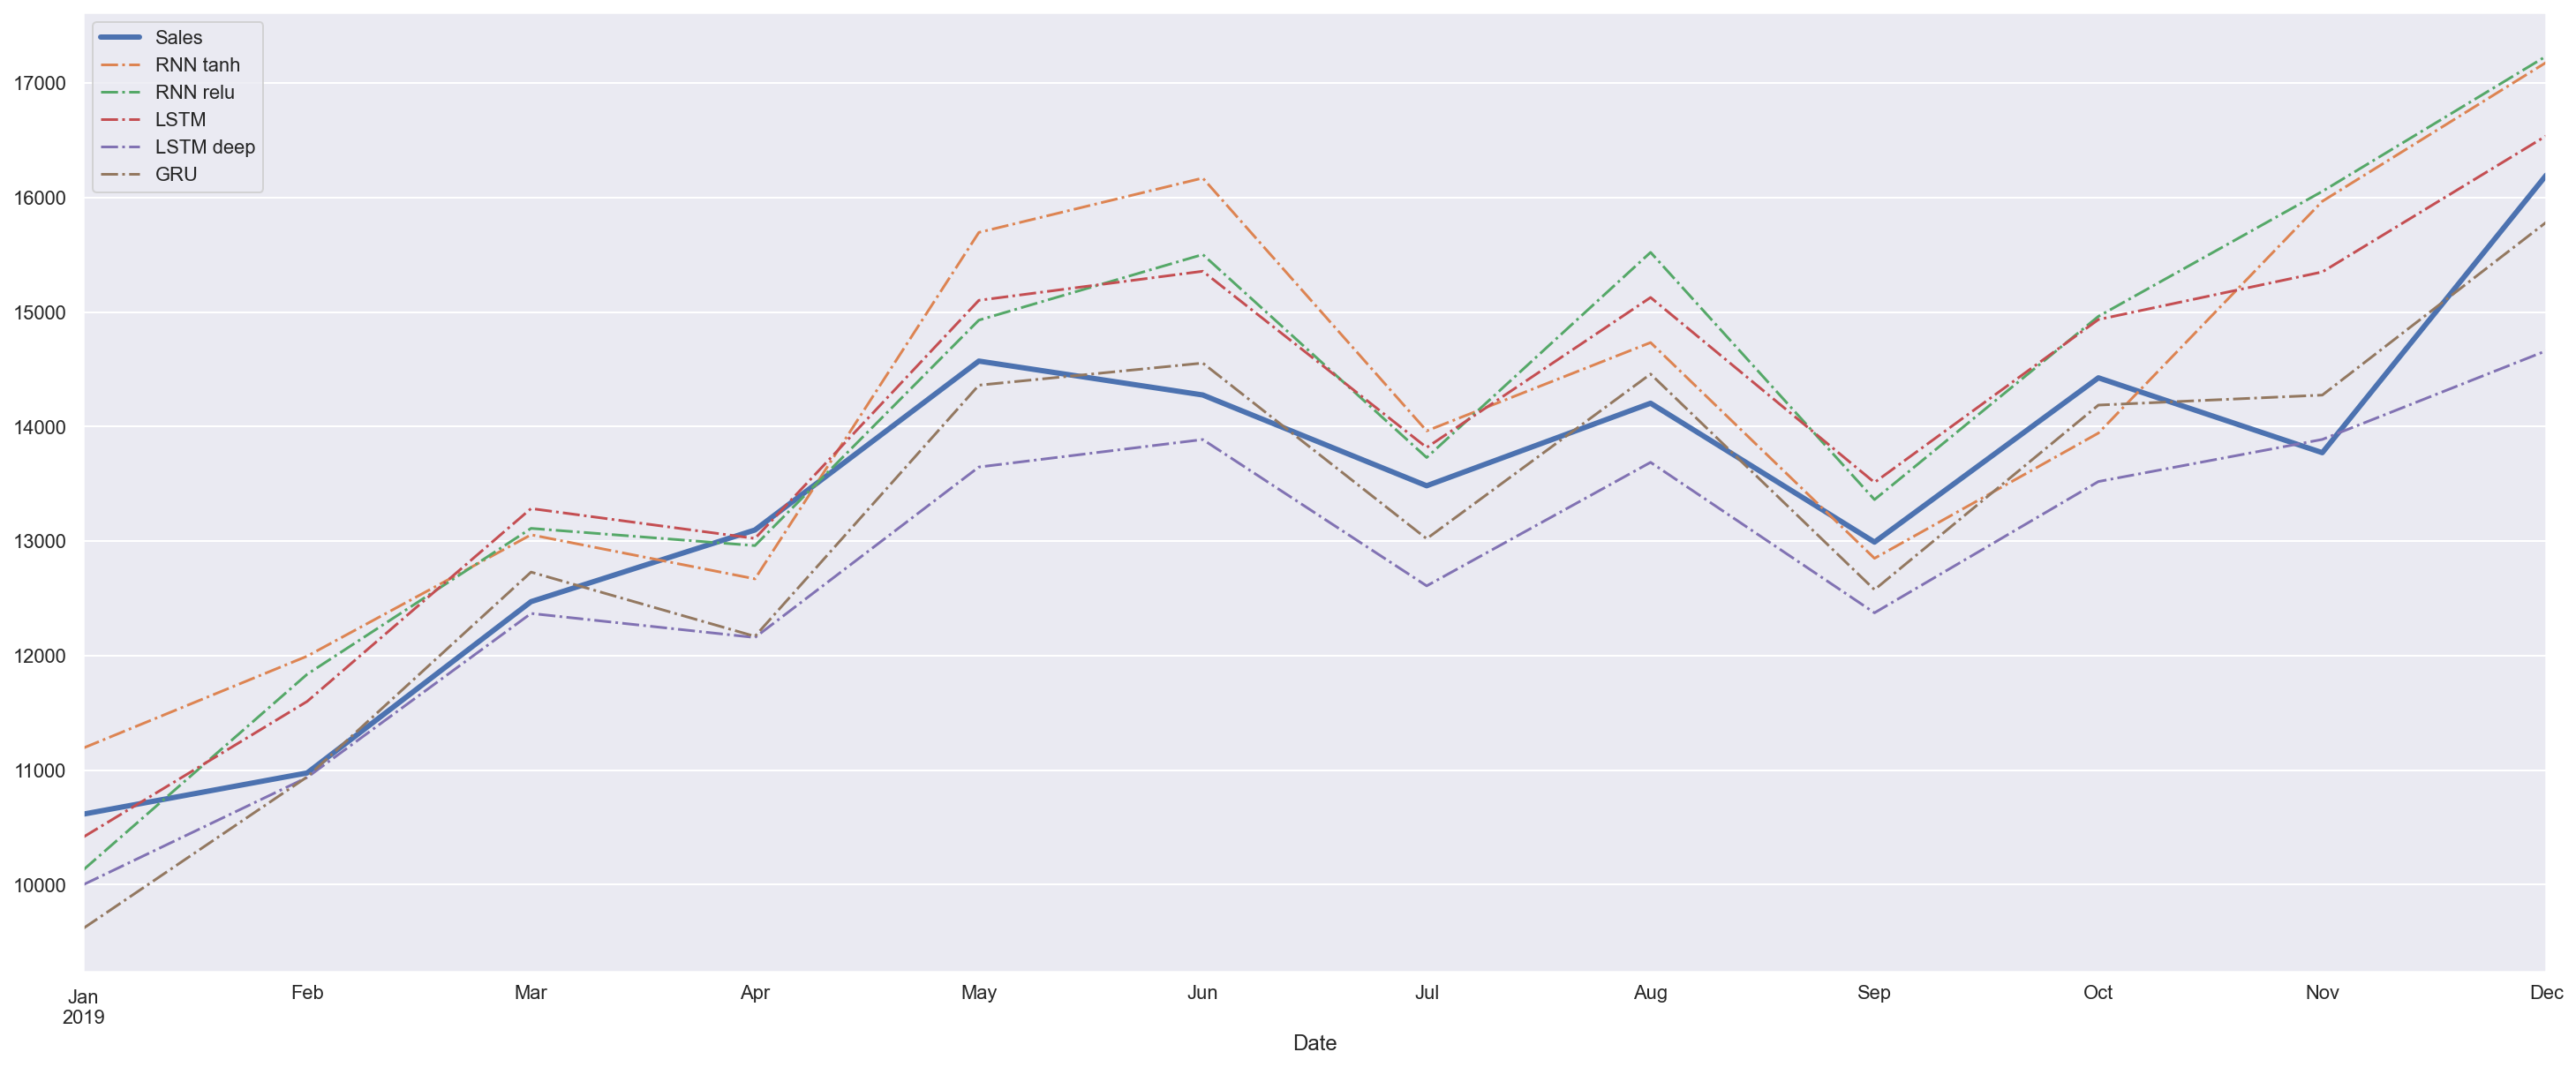

In [60]:
fig = plt.figure(figsize=(25,10))
ax = fig.subplots()
test["Sales"].plot(linewidth=3, ax=ax)
test["RNN tanh"].plot(linestyle="-.", ax=ax)
test["RNN relu"].plot(linestyle="-.", ax=ax)
test["LSTM"].plot(linestyle="-.", ax=ax)
test["LSTM deep"].plot(linestyle="-.", ax=ax)
test["GRU"].plot(linestyle="-.", ax=ax)
ax.legend(["Sales", "RNN tanh", "RNN relu", "LSTM", "LSTM deep", "GRU"]);

### A numerical error: RMSE

We can associate an error to each model in order to have a _satisficing metric_ to compare.

In [61]:
print(f"RNN tanh: {mean_squared_error(test['Sales'], test['RNN tanh'], squared=False)}")
print(f"RNN relu: {mean_squared_error(test['Sales'], test['RNN relu'], squared=False)}")
print(f"LSTM: {mean_squared_error(test['Sales'], test['LSTM'], squared=False)}")
print(f"LSTM deep: {mean_squared_error(test['Sales'], test['LSTM deep'], squared=False)}")
print(f"GRU: {mean_squared_error(test['Sales'], test['GRU'], squared=False)}")

RNN tanh: 1052.8585270334938
RNN relu: 981.1950248202508
LSTM: 744.5273268948973
LSTM deep: 757.2299349062512
GRU: 498.27186865038215


---
### Exercise 

Try to build a prophet model to forecast alcohol sales for year $2019$ and an RMSE less than $500$ units.